# IS5126 Individual Assignment 1: 
Building a Specialized Wikipedia Research Assistant
---
**Name:** Junyi Zhang

**Chosen Research Domain:** Technology/Innovation Research Assistant

**Why this domain?**  
I chose Option 2: Technologies/Innovations because I am interested in how new technologies are transforming the financial sector and creating both opportunities and risks. Within this domain, I focus on the subfield of Fraud Prevention and Detection Technologies, as they closely align with my career interests in digital finance and risk management. I am especially interested in understanding the evolution of these technologies.

**Selected Wikipedia Articles**
1. Fraud: https://en.wikipedia.org/wiki/Fraud
2. Credit card fraud: https://en.wikipedia.org/wiki/Credit_card_fraud
3. Internet fraud: https://en.wikipedia.org/wiki/Internet_fraud
4. Phishing: https://en.wikipedia.org/wiki/Phishing
5. Multi-factor authentication: https://en.wikipedia.org/wiki/Multi-factor_authentication
6. Data analysis for fraud detection: https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection
7. Regulatory technology: https://en.wikipedia.org/wiki/Regulatory_technology

**Cohesion**
The seven articles include the general article Fraud, which provides an overview of the concept. Credit Card Fraud, Internet Fraud, and Phishing illustrate key fraud techniques. Meanwhile, Multi-factor Authentication, Data Analysis for Fraud Detection, and Regulatory Technology present modern prevention and detection technologies. Together, these articles are closely related and collectively address questions such as: “How did these technologies evolve?”, “What were the key innovations?”, and “Who were the major contributors?”

## Setup and Configuration  
First, install required packages and import libraries

In [1]:
!pip install crawl4ai openai sentence-transformers numpy pandas

In [2]:
import asyncio
import json
import time
import re
from typing import List, Dict, Any, Optional
import pandas as pd
import numpy as np

# Crawl4AI imports
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig
from crawl4ai.extraction_strategy import JsonCssExtractionStrategy, LLMExtractionStrategy
from crawl4ai.chunking_strategy import RegexChunking, SlidingWindowChunking
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator
from crawl4ai import CacheMode

# LLM and embedding imports
from pydantic import BaseModel, Field, ValidationError #used for extracting structured data
from openai import OpenAI
from sentence_transformers import SentenceTransformer #used for embedding generation
from sklearn.metrics.pairwise import cosine_similarity #used for similarity calculation

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Configuration - Update with your API keys
import os
import getpass

os.environ["TOKENIZERS_PARALLELISM"] = "false" # To suppress tokenizer parallelism warnings

api_key = getpass.getpass(prompt="Enter your OpenAI API key (it will not display when you enter):")

# If the user enters nothing, use the default key
if not api_key:
    api_key = "your-openai-api-key-here"
    print(f"No API key entered. Using this as default: {api_key}")

# Set the environment variable with the key
os.environ['OPENAI_API_KEY'] = api_key

# Initialize OpenAI client
client = OpenAI()  if os.environ['OPENAI_API_KEY'] != "your-openai-api-key-here" else None # Automatically uses OPENAI_API_KEY env var

In [4]:
# Initialize embedding model (runs locally, no API key needed)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

print("✅ Setup complete!")

✅ Setup complete!


## Part 1: Wikipedia Scraper Implementation:

**Requirements recap**  
- Scrape at least 5 different Wikipedia articles within your chosen domain
- Articles should be thematically related to enable meaningful analysis
- Extract article title, main content, and key sections
- Handle rate limiting and error cases gracefully
- Clean and preprocess the scraped text for LLM consumption

**Focus:** robust scraping, error handling, content cleaning, rate limiting, and code quality.


### 1.1 WikipediaScraper class

In [5]:
class WikipediaScraper:
    def __init__(self, base_urls: List[str], delay_s=1.5, max_retries=3, timeout=15):
        self.base_urls = base_urls # list of Wikipedia article URLs
        self.delay_s = delay_s  # delay between requests to avoid rate limiting
        self.max_retries = max_retries  # number of retries on failure
        self.timeout = timeout  # Maximum wait time for each request
        if AsyncWebCrawler is None:
            raise ImportError("crawl4ai is not installed or failed to import.")
        self.crawler = AsyncWebCrawler

    # -------- NEW: content validator (soft-404 / thin content / disambiguation) --------
    def _validate_article(self, md: str, html: Optional[str] = None) -> (bool, str):
        """Return (is_valid, reason). Detects 'soft-404', 'disambiguation', or 'thin content'."""
        text = (md or "").lower()

        # 1) Typical “entry does not exist” prompt
        if "wikipedia does not have an article with this exact name" in text:
            return False, "soft_404:noarticletext"

        # 2) HTML layer noarticletext container (more accurate)
        if html:
            h = html.lower()
            if ('class="noarticletext"' in h) or ('id="noarticletext"' in h):
                return False, "soft_404:noarticletext_div"

        # 3) Disambiguation page
        disamb_signals_text = [
        "disambiguation page",
        "this disambiguation page",
        "may refer to:",
        "may also refer to:",
        "can refer to:"
        ]

        if any(sig in text for sig in disamb_signals_text):
            return False, "disambiguation_page:text"

        if "disambiguation" in text and "may refer to" in text:
            return False, "disambiguation_page"
        
        if html:
            h = html.lower()
            # Common HTML identifier
            if ('class="mw-disambig"' in h) or ('id="disambigbox"' in h):
                return False, "disambiguation_page:html_flag"
            # In the footer categories, it contains Disambiguation pages
            if 'title="category:disambiguation pages"' in h:
                return False, "disambiguation_page:category"

        # 4) Structure and length threshold (to prevent empty/shell pages)
        words = re.findall(r"\w+", md or "")
        word_count = len(words)
        h2_count = sum(1 for line in (md or "").splitlines() if line.strip().startswith("##"))
        if word_count < 200 or (h2_count == 0 and word_count < 400):
            return False, f"thin_content:words={word_count},h2={h2_count}"

        return True, "ok"
    


    """Scrape a single Wikipedia article"""
    async def scrape_article(self, url: str) -> Dict[str, Any]:

        config = CrawlerRunConfig( # Configuration for each crawl run
        wait_for="body", # wait for full page load
        markdown_generator=DefaultMarkdownGenerator(), # Convert raw HTML into clean Markdown text for easier reading and downstream LLM processing
        cache_mode=CacheMode.WRITE_ONLY, # Cache results to speed up future runs
        verbose=True # Print detailed logs during crawling
        )

        async with self.crawler(verbose=True) as crawler:
            attempt = 1
            last_err = None
            while attempt < self.max_retries+1: # run if attempt<3
                try:
                    result = await crawler.arun(url=url,config=config)
                    md = result.markdown or ""
                    title = self._extract_title_from_markdown(md) or url.split("/")[-1].replace("_", " ")
                    cleaned = self.clean_content(md)

                    html = getattr(result, "html", None)
                    is_valid, reason = self._validate_article(cleaned or md, html)

                    if not is_valid:
                        return {
                            "title": title.strip(),
                            "url": url,
                            "markdown": md,
                            "markdown_length": len(md),
                            "cleaned": cleaned,
                            "cleaned_length": len(cleaned),
                            "metadata": getattr(result, "metadata", None),
                            "crawl_time": time.time(),
                            "status": "invalid",
                            "invalid_reason": reason
                            }

                    # Otherwise, return normal results
                    return {
                        "title": title.strip(),
                        "url": url,
                        "markdown": md,
                        "markdown_length": len(md),
                        "cleaned": cleaned,
                        "cleaned_length": len(cleaned),
                        "metadata": getattr(result, "metadata", None),
                        "crawl_time": time.time(),
                        "status": "ok"
                        }

                except Exception as e:
                    print(f"Retrying {url} (attempt {attempt}/{self.max_retries}) due to error: {e}")
                    last_err = e
                    attempt += 1
                    await asyncio.sleep(self.delay_s * attempt)  # backoff: slow down gradually to improve the success rate
            raise RuntimeError(f"Failed to scrape {url} after {self.max_retries} attempts. Last error: {last_err}")


    """Scrape all articles in the URL list."""
    async def scrape_multiple(self) -> List[Dict[str, Any]]:
        crawled_data = []
        for i, url in enumerate(self.base_urls, start=1):
            print(f"[{i}/{len(self.base_urls)}] Scraping:", url)
            try:
                art = await self.scrape_article(url)
                crawled_data.append(art)
                await asyncio.sleep(self.delay_s)  # rate limit between requests
                print(f"Successfully scraped: {url} ({art['cleaned_length']} chars cleaned)")
            except Exception as e:
                print(f"Error scraping {url}: {e}")
        return crawled_data



    """Minimal cleaning: strip, collapse extra whitespace, remove sup/citation markers if present."""
    def clean_content(self, raw_content: str) -> str:
        if not raw_content:
            return ""
        # Normalize line breaks and whitespace
        text = raw_content.replace("\r\n", "\n").replace("\r", " ")

        # === Keep Main body, start from first # and end at References/See also/External links etc.===
        #find first H1
        m = re.search(r'^\s*#\s+', text, flags=re.M)
        if m:
            text = text[m.start():]

        # Cut off at References/Notes/Citations/Bibliography/Further reading/External links/See also
        stop = re.search(
            r'^\s{0,3}#{1,6}\s+(References|Notes|Citations|Bibliography|Further reading|External links|See also)\b',
            text, flags=re.I | re.M
            )
        if stop:
            text = text[:stop.start()]

        # Remove Markdown image tags ![alt text](url)
        text = re.sub(r'!\[[^\]]*\]\([^)]+\)', '', text)
        # Remove HTML comments <!-- comment -->
        text = re.sub(r'<!--.*?-->', '', text, flags=re.S)
        # Remove inline citation brackets like [1], [2], etc.
        text = re.sub(r"\[\d+\]", "", text)
        # # Remove superscript-style footnotes  ^[...]
        text = re.sub(r"\^\[[^\]]+\]", "", text)
        # Remove [edit] markers
        text = re.sub(r'\b\[edit\]\b', '', text, flags=re.I)
        # Collapse multiple spaces
        text = re.sub(r"[ \t]+", " ", text)
        # Trim long consecutive newlines
        text = re.sub(r"\n{3,}", "\n\n", text)
        # Remove the Wikipedia header language list :
        # - Delete everything between "languages" and "From Wikipedia"
        text = re.sub(r"^.*?From Wikipedia, the free encyclopedia", "From Wikipedia, the free encyclopedia", text, flags=re.S)
        # Remove toolbar sections such as "Tools", "Print/export", and "In other projects":
        # - Delete everything starting from "Tools" up to the beginning of the main content
        text = re.sub(r"(Tools|Print/export|In other projects).*?(?=\n[A-Z])", "", text, flags=re.S)
        
        return text.strip()


    """Extract the title from the markdown content."""
    def _extract_title_from_markdown(self, md: str) -> Optional[str]: # Input: a Markdown-formatted text (string). Output: a string (the title), or None if no title is found.
        for line in md.splitlines():
            line = line.strip()
            if line.startswith("# "):  # first H1
                return line[2:]
        return None

### 1.2 Demonstration of scraping

In [6]:
# --- Scrape ---
wiki_urls = [
    "https://en.wikipedia.org/wiki/Fraud",
    "https://en.wikipedia.org/wiki/Credit_card_fraud",
    "https://en.wikipedia.org/wiki/Internet_fraud",
    "https://en.wikipedia.org/wiki/Phishing",
    "https://en.wikipedia.org/wiki/Multi-factor_authentication",
    "https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection",
    "https://en.wikipedia.org/wiki/Regulatory_technology"
]

scraper = WikipediaScraper(wiki_urls)
scraped_articles = await scraper.scrape_multiple()
print(f"Scraped {len(scraped_articles)} articles.")

[1/7] Scraping: https://en.wikipedia.org/wiki/Fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 0.90s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 0.21s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 1.11s 

Successfully scraped: https://en.wikipedia.org/wiki/Fraud (68700 chars cleaned)
[2/7] Scraping: https://en.wikipedia.org/wiki/Credit_card_fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.59s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.10s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.70s 

Successfully scraped: https://en.wikipedia.org/wiki/Credit_card_fraud (53157 chars cleaned)
[3/7] Scraping: https://en.wikipedia.org/wiki/Internet_fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.60s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.07s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.67s 

Successfully scraped: https://en.wikipedia.org/wiki/Internet_fraud (17646 chars cleaned)
[4/7] Scraping: https://en.wikipedia.org/wiki/Phishing


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 1.66s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.17s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 1.83s 

Successfully scraped: https://en.wikipedia.org/wiki/Phishing (52402 chars cleaned)
[5/7] Scraping: https://en.wikipedia.org/wiki/Multi-factor_authentication


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.59s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.09s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.68s 

Successfully scraped: https://en.wikipedia.org/wiki/Multi-factor_authentication (38215 chars cleaned)
[6/7] Scraping: https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.57s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.04s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.62s 

Successfully scraped: https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection (20136 chars cleaned)
[7/7] Scraping: https://en.wikipedia.org/wiki/Regulatory_technology


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.56s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.03s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.58s 

Successfully scraped: https://en.wikipedia.org/wiki/Regulatory_technology (5823 chars cleaned)
Scraped 7 articles.


In [7]:
# --- Preview of scraped articles ---
for art in scraped_articles[:3]: # preview first 3 articles
    print("Title:", art['title'])
    print("URL: ", art['url'])
    print("Cleaned content preview:", art['cleaned'][:500], "...\n")
    print("Length of cleaned content:", art['cleaned_length'])


Title: Fraud
URL:  https://en.wikipedia.org/wiki/Fraud
Cleaned content preview: From Wikipedia, the free encyclopedia
Intentional deception to gain unlawfully
For other uses, see [Fraud (disambiguation)](https://en.wikipedia.org/wiki/Fraud_\(disambiguation\) "Fraud \(disambiguation\)").
"Phony" redirects here. For the Vocaloid song, see [Phony (song)](https://en.wikipedia.org/wiki/Phony_\(song\) "Phony \(song\)").
[](https://en.wikipedia.org/wiki/File:Handcuffs_icon.svg) 
--- 
[Criminal law](https://en.wikipedia.org/wiki/Criminal_law "Criminal law") 
[Elements](https://en.w ...

Length of cleaned content: 68700
Title: Credit card fraud
URL:  https://en.wikipedia.org/wiki/Credit_card_fraud
Cleaned content preview: From Wikipedia, the free encyclopedia
Financial crime
This article is about all types of credit card fraud. For organised trade and laundering of credit card information, see [Carding (fraud)](https://en.wikipedia.org/wiki/Carding_\(fraud\) "Carding \(fraud\)").
[](https://en.

### 1.3 Explanation of how articles relate to the research domain
- *Fraud* introduces the general definition, historical background, types of fraud and detection methods.
- *Credit card fraud* and *Internet fraud* represent how the fraud envolved with the develop of internet and digital payment.
- *Phishing* demonstrate how criminals exploit both human and technological vulnerabilities.
- *Multi-factor authentication*, *Data analysis for fraud detection* and *Regulatory technology* illustrates the defensive innovations developed to prevent and detect fraud in the digital era.

Together, these 7 articles cover both the "problem space" and the "solution space". This makes them an ideal, cohesive set for the assignment under the Fraud Prevention and Detection Technologies domain.

### 1.4 Error Handling Examples

In [8]:
# --- URL entered does not exist or is a disambiguation page ---
bad_urls=["https://en.wikipedia.org/wiki/Phishing", # good
          "https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345", # page does not exist
          "https://en.wikipedia.org/wiki/Mercury" # disambiguation page
          ]
s = WikipediaScraper(bad_urls)
res = await s.scrape_multiple()
for r in res:
    print(r["url"], "=>", r.get("status"), r.get("invalid_reason"))

[1/3] Scraping: https://en.wikipedia.org/wiki/Phishing


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.65s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.17s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.83s 

Successfully scraped: https://en.wikipedia.org/wiki/Phishing (52402 chars cleaned)
[2/3] Scraping: https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345                                             |
✓ | ⏱: 0.55s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345                                             |
✓ | ⏱: 0.02s 

[COMPLETE] ● https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345                                             |
✓ | ⏱: 0.57s 

Successfully scraped: https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345 (5778 chars cleaned)
[3/3] Scraping: https://en.wikipedia.org/wiki/Mercury


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Mercury                                                                |
✓ | ⏱: 0.57s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Mercury                                                                |
✓ | ⏱: 0.04s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Mercury                                                                |
✓ | ⏱: 0.61s 

Successfully scraped: https://en.wikipedia.org/wiki/Mercury (16816 chars cleaned)
https://en.wikipedia.org/wiki/Phishing => ok None
https://en.wikipedia.org/wiki/ThisPageDoesNotExist_12345 => invalid soft_404:noarticletext
https://en.wikipedia.org/wiki/Mercury => invalid disambiguation_page:text


## Part 2: Structured Data Extraction

**Requirements recap:**
- Define Pydantic models appropriate for your chosen domain
- Extract at least 5 different data fields relevant to your research focus
- Handle articles with varying structures
- Implement proper error handling for API calls

**Focus:** Pydantic model design with appropriate field types, Consistent and high-quality extractions, API error handling, Batch processing, Validation.

### 2.1 Define Domain-specific Pydantic model

In [9]:
# ---------- (A) Domain-specific Pydantic model ----------
# Design 8 fields (must include at least one List[str] and one str)
class TechInnovationExtraction(BaseModel):
    tech_name: str = Field(description="Main name of the technology or innovation, use ONLY the article title exactly as given (do not include aliases or parentheses)")
    summary: str = Field(description="Concise 2-3 sentence overview capturing the essence, scope, and significance of the technology or topic")
    evolution_timeline: List[str] = Field(description="Chronological milestones in 'YYYY: event' or similar format to show how the technology evolved over time")
    key_innovations: List[str] = Field(description="Breakthroughs, novel features, or inventions driving this technology forward")
    contributors: List[str] = Field(description="Major contributors such as inventors, companies, or institutions")
    applications: List[str] = Field(description="Industries, sectors, or use cases where the technology is applied")
    challenges: List[str] = Field(description="Current challenges, limitations, and controversies facing this technology/topic")
    mitigations: List[str] = Field(description="Controls, safeguards, or best practices to maximize benefits and reduce risks")

# Let's see what the JSON schema looks like
print("📋 Generated JSON Schema Preview:")
print(json.dumps(TechInnovationExtraction.model_json_schema(), indent=2)[:1000] + "...")


📋 Generated JSON Schema Preview:
{
  "properties": {
    "tech_name": {
      "description": "Main name of the technology or innovation, use ONLY the article title exactly as given (do not include aliases or parentheses)",
      "title": "Tech Name",
      "type": "string"
    },
    "summary": {
      "description": "Concise 2-3 sentence overview capturing the essence, scope, and significance of the technology or topic",
      "title": "Summary",
      "type": "string"
    },
    "evolution_timeline": {
      "description": "Chronological milestones in 'YYYY: event' or similar format to show how the technology evolved over time",
      "items": {
        "type": "string"
      },
      "title": "Evolution Timeline",
      "type": "array"
    },
    "key_innovations": {
      "description": "Breakthroughs, novel features, or inventions driving this technology forward",
      "items": {
        "type": "string"
      },
      "title": "Key Innovations",
      "type": "array"
    },
    

### 2.2 Implementation of structured extraction functions

In [10]:
import random, traceback
from typing import Tuple

# Common OpenAI SDK exception types
from openai import (
    APIError,
    APIConnectionError,
    APITimeoutError,
    RateLimitError,
    BadRequestError,
    AuthenticationError,
    PermissionDeniedError,
    NotFoundError,
    UnprocessableEntityError,
    InternalServerError,
)

In [11]:
class StructuredExtractor:
    def __init__(self, model_name: str = "gpt-4o-mini", max_retries: int = 3, backoff_s: float = 1.5, last_error_snapshot: Optional[Dict[str, Any]] = None):
        self.model_name = model_name
        self.max_retries = max_retries
        self.backoff_s = backoff_s
        self.last_error_snapshot = None  # Save the details of the most recent failure (dict)

        # Check if the API key has been configured
        if client is None: # If the key is not correctly set in the config cell, initialization will not occur
            raise EnvironmentError("OPENAI_API_KEY is not set. Please run the configuration cell first.")

        # Initialize directly using environment variables
        self.client = OpenAI()

    def _classify_api_error(self, err: Exception) -> Tuple[str, bool]:
        """
        Returns (error_type, is_transient)
        - is_transient=True: retry is recommended (timeout/connection/rate limiting/5xx)
        - is_transient=False: do not retry (authentication/parameters/not found/insufficient quota/exceeded length, etc.)
        """
        if isinstance(err, (APITimeoutError, APIConnectionError, RateLimitError, InternalServerError, APIError)):
            return (err.__class__.__name__, True)
        if isinstance(err, (BadRequestError, AuthenticationError, PermissionDeniedError, NotFoundError, UnprocessableEntityError)):
            return (err.__class__.__name__, False)
        return (err.__class__.__name__, False)

    def _compute_backoff(self, attempt: int, retry_after_s: float = None) -> float:
        """
        Exponential backoff + jitter; use Retry-After first if available.  
        attempt starts from 1
        """
        if retry_after_s is not None:
            base = float(retry_after_s)
        else:
            base = self.backoff_s * (2 ** (attempt - 1))  # Exponent
        jitter = random.uniform(0, 0.5 * base)
        return min(30.0, base + jitter)  # Add an upper limit to avoid waiting too long



    # ---------- (1) Construct prompt ----------
    def _build_prompt(self, title: str, url: str, cleaned_markdown: str) -> List[Dict[str, str]]:
        """
        Construct system + user messages:
        - system: defines the model's role and output style
        - user: contains the article's title, URL, and the cleaned body text
        """
        system_msg = (
            "You are an expert information extractor for technology/innovation topics. "
            "Read the provided Wikipedia-like article and fill a STRICT JSON schema called "
            "'TechInnovationExtraction'. Be concise, factual, and avoid unverifiable claims. "
            "Prefer bullet-like phrases in list fields. If a field is weakly supported, infer cautiously "
            "or keep it minimal (do not hallucinate)."
        )
        user_msg = (
            f"TITLE: {title}\nURL: {url}\n\n"
            "TASK: Extract fields for the TechInnovationExtraction schema with the following keys:\n"
            "- tech_name (str)\n"
            "- summary (str)\n"
            "- evolution_timeline (List[str])\n"
            "- key_innovations (List[str])\n"
            "- contributors (List[str])\n"
            "- applications (List[str])\n"
            "- challenges (List[str])\n"
            "- mitigations (List[str])\n\n"
            "ARTICLE (cleaned markdown; may be truncated):\n"
            + cleaned_markdown
        )
        return [
            {"role": "system", "content": system_msg},
            {"role": "user",   "content": user_msg},
        ]
    
    # ---------- (2) Single-article extraction ----------
    def extract_structured_data(self, article: Dict[str, Any]) -> Optional[TechInnovationExtraction]:
        """
        Perform structured extraction for a single article;
        return TechInnovationExtraction on success, or None on failure.
        """
        title = article.get("title") or "Unknown"
        url = article.get("url") or ""
        cleaned = article.get("cleaned") or ""

        messages = self._build_prompt(title, url, cleaned)

        last_err: Optional[Exception] = None
        retries = 0

        for attempt in range(1, self.max_retries+1):
            try:
                # New version needs to use parse, the return value is a ParsedChatCompletion wrapper object -
                # the actual Pydantic instance should be retrieved from choices[0].message.parsed
                resp = self.client.chat.completions.parse(
                    model=self.model_name,
                    messages=messages,
                    # Ensure the output strictly conforms to the Pydantic model class TechInnovationExtraction
                    response_format=TechInnovationExtraction
                )
                msg = resp.choices[0].message
                extraction: Optional[TechInnovationExtraction] = getattr(msg, "parsed", None)

                if extraction is None: # If parsing failed, parsed will be None
                    raise ValueError("Schema parse failed: model output did not match TechInnovationExtraction")

                # Success: clear error snapshot
                self.last_error_snapshot = None

                # Fallback: if tech_name is empty, use the title instead
                if not extraction.tech_name or not extraction.tech_name.strip():
                    extraction.tech_name = title

                # Fallback: ensure all list fields are at least empty lists
                extraction.summary = extraction.summary or ""
                extraction.evolution_timeline = extraction.evolution_timeline or []
                extraction.key_innovations = extraction.key_innovations or []
                extraction.contributors = extraction.contributors or []
                extraction.applications = extraction.applications or []
                extraction.challenges = extraction.challenges or []
                extraction.mitigations = extraction.mitigations or []

                return extraction

            except ValidationError as ve:
                # Structure validation error: usually retry is meaningless, record and exit
                print(f"[ValidationError] {title}: {ve}")
                last_err = ve
                self.last_error_snapshot = {
                    "title": title,
                    "error_type": "ValidationError",
                    "message": str(ve),
                    "http_status": None,
                    "request_id": None,
                    "attempt": attempt,
                    "retries": retries,
                    "action": "no-retry",
                }
                break

            except Exception as e:
                err_type, is_transient = self._classify_api_error(e)
                # Other exceptions: network/timeout/rate limiting/5xx can be retried; parameters/authentication/not found/quota, etc. cannot be retried
                # Extract http_status / request_id / retry_after from the exception object whenever possible
                http_status = getattr(e, "status", None) or getattr(e, "http_status", None)
                request_id = None
                retry_after_s = None
                try:
                    resp = getattr(e, "response", None)
                    if resp is not None:
                        # In openai>=1, response.headers may contain x-request-id / retry-after
                        headers = getattr(resp, "headers", {}) or {}
                        request_id = headers.get("x-request-id") or headers.get("X-Request-ID")
                        ra = headers.get("retry-after") or headers.get("Retry-After")
                        if ra is not None:
                            retry_after_s = float(ra)
                except Exception:
                    pass
                
                print(f"[{err_type}] {title}: {e} (status={http_status}, request_id={request_id})")
                last_err = e

                if is_transient and attempt < self.max_retries:
                    retries += 1
                    sleep_s = self._compute_backoff(attempt, retry_after_s)
                    print(f"  ↻ will retry in {sleep_s:.1f}s (attempt {attempt+1}/{self.max_retries})")
                    time.sleep(sleep_s)
                    continue
                else:
                    # Non-retriable or reached the limit: write snapshot and exit loop
                    self.last_error_snapshot = {
                        "title": title,
                        "error_type": err_type,
                        "message": str(e),
                        "http_status": http_status,
                        "request_id": request_id,
                        "attempt": attempt,
                        "retries": retries,
                        "action": "give-up" if not is_transient else "max-retries-reached",
                        "traceback": "".join(traceback.format_exception_only(type(e), e)).strip(),
                    }
                    break

        print(f"[FAILED] Structured extraction for '{title}' after {self.max_retries} attempts. Last error: {last_err}")
        return None
    

     # ---------- (3) Batch Extraction ----------
    def batch_extract(self, articles: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Batch process multiple articles and return a unified structured list:
        [{ 'title': str, 'url': str, 'extraction': TechInnovationExtraction | None }, ...]
        """
        results: List[Dict[str, Any]] = []
        total = len(articles)
        for i, art in enumerate(articles, start=1):
            t = art.get("title", f"Article {i}")
            print(f"[{i}/{total}] Extracting: {t}")
            ext = self.extract_structured_data(art)
            results.append({
                "title": t,
                "url": art.get("url", ""),
                "extraction": ext,
                "error": None if ext is not None else (self.last_error_snapshot or {"message": "Unknown error"}),
                "retries": (self.last_error_snapshot or {}).get("retries", 0) if ext is None else 0,
            })
        return results

### 2.3 Examples showing extraction results

In [12]:
# ---------- Implement structuring ----------
extractor = StructuredExtractor(model_name="gpt-4o-mini")
structured_results = extractor.batch_extract(scraped_articles)

[1/7] Extracting: Fraud
[2/7] Extracting: Credit card fraud
[3/7] Extracting: Internet fraud
[4/7] Extracting: Phishing
[5/7] Extracting: Multi-factor authentication
[6/7] Extracting: Data analysis for fraud detection
[7/7] Extracting: Regulatory technology


In [13]:
# ---------- Implement structuring ----------
# Transform results to dataframe
df = pd.DataFrame([
    {
        "title": r["title"],
        "url": r["url"],
        "tech_name": r["extraction"].tech_name if r["extraction"] else None,
        "summary": r["extraction"].summary if r["extraction"] else None,
        "evolution_timeline": r["extraction"].evolution_timeline if r["extraction"] else None,
        "key_innovations": r["extraction"].key_innovations if r["extraction"] else None,
        "contributors": r["extraction"].contributors if r["extraction"] else None,
        "applications": r["extraction"].applications if r["extraction"] else None,
        "challenges": r["extraction"].challenges if r["extraction"] else None,
        "mitigations": r["extraction"].mitigations if r["extraction"] else None
    }
    for r in structured_results
])

df


,title,url,tech_name,summary,evolution_timeline,key_innovations,contributors,applications,challenges,mitigations
0,Fraud,https://en.wikipedia.org/wiki/Fraud,Fraud,Fraud is the act of intentionally deceiving so...,[],[],[],"[Legal systems, Financial sectors, Insurance, ...","[Complexity of proving intent, Variability in ...","[Regulatory frameworks, Fraud detection techno..."
1,Credit card fraud,https://en.wikipedia.org/wiki/Credit_card_fraud,Credit card fraud,Credit card fraud encompasses fraudulent activ...,"[1970s: Emergence of credit cards, 1990s: Intr...",[Payment Card Industry Data Security Standard ...,[Payment Card Industry Security Standards Coun...,"[E-commerce, Retail transactions, Banking and ...","[Rising sophistication of fraud tactics, Limit...","[Regular monitoring of account activity, Use o..."
2,Internet fraud,https://en.wikipedia.org/wiki/Internet_fraud,Internet fraud,Internet fraud encompasses various deceptive p...,[1990s: Emergence of online fraud with the ris...,"[Social engineering techniques, Phishing schem...","[FBI, Center for Strategic and International S...","[Cybersecurity awareness, Fraud detection syst...","[Increasing sophistication of fraud schemes, L...","[Enhanced cybersecurity practices, Public awar..."
3,Phishing,https://en.wikipedia.org/wiki/Phishing,Phishing,Phishing is a form of social engineering that ...,[1995: The term 'phishing' first recorded in h...,"[Use of spoofed emails and websites, Man-in-th...",[Khan C. Smith (spammer credited with coining ...,"[Financial institutions, Cloud services, Email...",[Increasing sophistication of phishing techniq...,"[User education and awareness campaigns, Imple..."
4,Multi-factor authentication,https://en.wikipedia.org/wiki/Multi-factor_aut...,Multi-factor authentication,Multi-factor authentication (MFA) is an electr...,[1996: Initial concept of two-factor authentic...,[Combination of multiple authentication factor...,"[AT&T, Duo Security, Google, Apple, FIDO Allia...","[Online banking, E-commerce transactions, Corp...","[Vulnerability to phishing attacks, Fatigue at...",[Use of strong authenticator applications for ...
5,Data analysis for fraud detection,https://en.wikipedia.org/wiki/Data_analysis_fo...,Data analysis for fraud detection,Data analysis techniques are vital for detecti...,[2010: Recognition of the need for specialized...,"[Knowledge discovery in databases, Data mining...","[Forensic accountants, Machine learning resear...","[Financial services, E-commerce, Insurance, Co...",[High false positive rates in fraud detection ...,[Use of hybrid models combining expertise and ...
6,Regulatory technology,https://en.wikipedia.org/wiki/Regulatory_techn...,Regulatory technology,Regulatory technology (RegTech) utilizes infor...,[2014: Vision of technology-led regulation pro...,"[Regulatory monitoring tools, Automated compli...","[Financial Conduct Authority (FCA), UK Governm...","[Financial services, Healthcare, Gaming, Pharm...","[High costs of compliance regulation, Evolving...",[Adopting best practices for compliance automa...


### 2.4 Error Handling & Validation
We implemented error handling for API calls with try/except blocks and retry with exponential backoff. When the request fails, the system retries several times before giving up. If all retries fail, a clear error message is printed to indicate the reason, e.g.:

In [14]:
# Intentional wrong model
# Demonstration will not crash and will show retries and error metadata
demo_extractor = StructuredExtractor(model_name="gpt-4o-mini-NOTEXIST")
demo_results = demo_extractor.batch_extract([
    {"title": "BadModel", "url": "", "cleaned": "test content"},
])

[1/1] Extracting: BadModel
[NotFoundError] BadModel: Error code: 404 - {'error': {'message': 'The model `gpt-4o-mini-NOTEXIST` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}} (status=None, request_id=req_4975c6f8920e4e979a76ace9ba139c35)
  ↻ will retry in 2.0s (attempt 2/3)
[NotFoundError] BadModel: Error code: 404 - {'error': {'message': 'The model `gpt-4o-mini-NOTEXIST` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}} (status=None, request_id=req_0de25b3229ee4d369948fe864363251c)
  ↻ will retry in 3.1s (attempt 3/3)
[NotFoundError] BadModel: Error code: 404 - {'error': {'message': 'The model `gpt-4o-mini-NOTEXIST` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}} (status=None, request_id=req_9d6cbfd5374a4447b655a12fd7ef9761)
[FAILED] Structured extraction f

This shows that the program does not crash on API errors and provides traceable diagnostics for debugging.

### 2.5 Analysis of what patterns emerge from the structured data

#### 2.5.1 Evolution timeline

In [15]:
# Show detailed infomration of evolution_timeline in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["evolution_timeline"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
[]

=== TITLE: Credit card fraud ===
['1970s: Emergence of credit cards', '1990s: Introduction of anti-fraud measures', '2000s: Rise of online transactions and related fraud', '2010s: Development of EMV chip technology', '2020s: Increased use of AI and machine learning for fraud detection']

=== TITLE: Internet fraud ===
['1990s: Emergence of online fraud with the rise of the Internet', '2005: Increase in counterfeit postal money orders reported', '2017: FBI reports 300,000 complaints with $1.4 billion in losses', '2018: CSIS and McAfee estimate $600 billion in annual cybercrime cost']

=== TITLE: Phishing ===
["1995: The term 'phishing' first recorded in hacker communities", '2001: First known direct phishing attempt against a payment system (E-gold)', '2010s: Significant increase in phishing attacks, targeting various sectors including retail and government', '2020s: Rise of phishing as a service (PhaaS) and advanced techniques like AiTM attacks']

=== TITLE: Mu

**Analysis from evolution_timeline in results**
- Early stage (1990s–2000s): Dominated by traditional forms of fraud and the first email scams; data mining and early machine learning methods began to be introduced.
- Middle stage (2000s–2015): Credit card fraud became a major issue in the financial sector, and payment system attacks and online auction fraud emerged; at the same time, authentication technologies such as MFA and FIDO2 gradually developed.
- Recent stage (2017–2021): Fraud expanded rapidly in scale (e.g., the FBI reported 300,000 complaints in 2017; global cybercrime losses reached USD 600 billion in 2018; nearly half of Americans reported experiencing credit card fraud in 2021).
- Latest trends (2024–2025): More sophisticated new attack methods have appeared (e.g., AiTM attacks in 2024, and the rise of “subscription traps” in online services in 2025); meanwhile, regulators continue to introduce mandatory security measures (such as the PSD2 strong customer authentication requirement in 2019).

#### 2.5.2 Key innovations

In [16]:
# Show detailed information of key_innovations in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["key_innovations"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
[]

=== TITLE: Credit card fraud ===
['Payment Card Industry Data Security Standard (PCI DSS)', 'EMV Chip technology', 'Artificial Intelligence and machine learning for fraud detection', 'Tokenization of payment data', 'Multi-factor Authentication']

=== TITLE: Internet fraud ===
['Social engineering techniques', 'Phishing schemes', 'Cryptocurrency frauds', 'Romance scams', 'Online ticket scams', 'Use of gift cards in fraud', 'Subscription traps']

=== TITLE: Phishing ===
['Use of spoofed emails and websites', 'Man-in-the-Middle (MitM) phishing techniques', 'Multi-factor authentication (MFA) targeted attacks', 'Phishing kits for easily impersonating legitimate sites', 'Adversary-in-the-middle (AiTM) phishing attacks']

=== TITLE: Multi-factor authentication ===
['Combination of multiple authentication factors (knowledge, possession, and inherence)', 'Use of mobile devices for authentication (SMS, push notifications)', 'Time-based one-time passwords (TOTP) from aut

**Analysis from key_innovations in results**
- Fraud: Digital fraud techniques, online identity theft, social engineering, fraud detection algorithms, predictive analytics.
- Credit card fraud: PCI DSS, AI for fraud detection, ML techniques, EMV chip technology, 3-D Secure verification
- Internet fraud: Phishing, romance scams, cryptocurrency fraud, social engineering, ticket scams, gift card fraud, call forwarding scams.
- Phishing: Email phishing, spear phishing, vishing, smishing, man-in-the-middle phishing, PhaaS, real-time relay kits.
- MFA: Multi-factor combinations (knowledge, possession, inherence), biometric verification, mobile-based authentication (apps, SMS codes).
- Data analysis for fraud detection: Data mining, machine learning, AI, regression analysis, clustering, knowledge discovery in databases, real-time anomaly detection.
- RegTech: Regulatory monitoring systems, automated compliance reporting, enhanced transparency, cost-saving compliance solutions.

In summary,
- Commonality: Heavy reliance on AI/ML and advanced analytics.
- Trend: Authentication and payment security increasingly strengthened (MFA, biometrics, EMV).
- Pattern: Balance of automation on both attack (phishing kits) and defense (real-time detection).

#### 2.5.3 Applications

In [17]:
# Show detailed information of applications in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["applications"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
['Legal systems', 'Financial sectors', 'Insurance', 'Internet services', 'Consumer protection']

=== TITLE: Credit card fraud ===
['E-commerce', 'Retail transactions', 'Banking and finance', 'Digital wallets', 'Insurance']

=== TITLE: Internet fraud ===
['Cybersecurity awareness', 'Fraud detection systems', 'Legal and law enforcement investigations', 'Consumer protection']

=== TITLE: Phishing ===
['Financial institutions', 'Cloud services', 'Email services', 'Social media platforms', 'Corporate security training']

=== TITLE: Multi-factor authentication ===
['Online banking', 'E-commerce transactions', 'Corporate access control', 'Healthcare data protection', 'Government security protocols']

=== TITLE: Data analysis for fraud detection ===
['Financial services', 'E-commerce', 'Insurance', 'Corporate fraud investigations', 'Government agencies', 'Law enforcement']

=== TITLE: Regulatory technology ===
['Financial services', 'Healthcare', 'Gaming', 'Pharmaceutical

**Analysis from applications in results**

Commonalities
- Fraud and anti-fraud applications are heavily concentrated in e-commerce and online shopping, where transaction-related risks lead to significant financial losses.
- Anti-fraud technologies extend beyond finance into healthcare, enterprise security, and government systems, showing broader relevance.

Trends
- Shift from traditional finance to digital platforms, with more fraud cases in e-commerce, online shopping, and subscription services.
- Expansion from financial services to multiple industries, including healthcare, telecom, gaming, pharmaceuticals, energy, and aviation.
- Growth of specialized prevention services and RegTech, showing a move toward systemic, platform-based fraud mitigation.

Patterns
- Whether it is traditional fraud, credit card fraud, or data analysis, the focus has consistently been on banking and payment systems.
- Digitalization has diversified fraud risks, from e-commerce and online shopping to cybersecurity and identity theft.
- Cross-industry adoption indicates fraud prevention is no longer sector-specific but a universal requirement across critical industries.

#### 2.5.4 Challenges

In [18]:
# Show detailed information of challenges in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["challenges"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
['Complexity of proving intent', 'Variability in legal definitions', 'Detection in digital environments', 'High rate of non-reporting']

=== TITLE: Credit card fraud ===
['Rising sophistication of fraud tactics', 'Limited reporting of fraud incidents', 'Difficulties in detection due to low transaction fraud incidence rates', 'Privacy issues with data sharing']

=== TITLE: Internet fraud ===
['Increasing sophistication of fraud schemes', 'Low reporting rates for fraud victims', 'Difficulty in tracing perpetrators across borders', 'Evolving methods and technologies used by scammers']

=== TITLE: Phishing ===
['Increasing sophistication of phishing techniques', 'Targeting of advanced security measures like MFA', 'Rise in public apathy towards phishing awareness', 'Persistent success of phishing campaigns despite education']

=== TITLE: Multi-factor authentication ===
['Vulnerability to phishing attacks', 'Fatigue attacks leading to user errors', 'Reliance on SMS whic

**Analysis from challenges in results**

Commonalities
- The article Fraud summarizes major challenges, including underreporting of fraud cases, difficulties in prosecuting cross-border fraud, and fraud detection in emerging technologies.
- The challenges of anti-fraud techniques mainly focus on the data and privacy dilemma: fraud detection relies heavily on large datasets but faces issues of privacy protection, data gaps, and high false-positive rates.

Trends
- From simple to complex: Techniques such as phishing and credit card fraud continue to evolve (e.g., AiTM attacks bypassing MFA).
- From local to global: Fraud now spans jurisdictions and borders, making regulation and enforcement increasingly difficult.
- Lagging defenses: Prevention methods based on historical data and rules often fall behind fraudsters’ new tactics.

Patterns
- Globalization is inevitable: As fraud becomes increasingly cross-border, no single country or institution can address it alone, requiring international cooperation.
- Cycle of escalation: Fraud methods evolve → defense technologies respond → new fraud methods emerge again, forming a continuous loop.

#### 2.5.5 Mitigations

In [19]:
# Show detailed information of mitigations in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["mitigations"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
['Regulatory frameworks', 'Fraud detection technologies', 'Consumer education and awareness', 'Stronger legal penalties']

=== TITLE: Credit card fraud ===
['Regular monitoring of account activity', 'Use of encryption and tokenization', 'Implementation of robust authentication measures', 'Education on phishing and identity theft prevention', 'Collaboration between financial institutions for fraud detection']

=== TITLE: Internet fraud ===
['Enhanced cybersecurity practices', 'Public awareness campaigns', 'Fraud detection algorithms', 'Reporting tools for victims', 'Collaboration between law enforcement and tech companies']

=== TITLE: Phishing ===
['User education and awareness campaigns', 'Implementation of multi-factor authentication', 'Spam filters and anti-phishing software', 'Regular monitoring and reporting of phishing incidents', 'Legislation against phishing practices']

=== TITLE: Multi-factor authentication ===
['Use of strong authenticator applications 

**Analysis from mitigations in results**

Commonalities
- Most articles highlight the importance of enhancing public awareness and education on fraud prevention, alongside the use of multi-factor authentication (MFA) and regular updates to fraud detection and prevention technologies.

Trends
- From single barriers to layered defenses: Combining technological tools (MFA, AI), regulatory measures, and public education to build comprehensive protection.
- From static controls to adaptive mechanisms: Systems, algorithms, and compliance processes must be continuously updated to keep pace with evolving fraud tactics.

Patterns
- Escalation cycle: Fraudsters innovate → defenders strengthen tools and regulations → fraudsters adapt again → defenses further evolve.
- Embedded compliance: Risk controls are increasingly integrated with legal frameworks, industry standards, and automated compliance platforms.

#### 2.5.6 Contributors

In [20]:
# Show detailed information of contributors in results
for r in structured_results:
    print("\n=== TITLE:", r["title"], "===")
    if r["extraction"]:
        print(r["extraction"].model_dump()["contributors"])  # Pydantic -> dict
    else:
        print("Extraction failed.")


=== TITLE: Fraud ===
[]

=== TITLE: Credit card fraud ===
['Payment Card Industry Security Standards Council', 'Financial institutions', 'Technology companies developing fraud detection solutions']

=== TITLE: Internet fraud ===
['FBI', 'Center for Strategic and International Studies', 'McAfee', 'Various perpetrators and scam organizations']

=== TITLE: Phishing ===
['Khan C. Smith (spammer credited with coining the term)', 'Microsoft (initiatives against phishing)', 'AOL (early enforcement actions)']

=== TITLE: Multi-factor authentication ===
['AT&T', 'Duo Security', 'Google', 'Apple', 'FIDO Alliance']

=== TITLE: Data analysis for fraud detection ===
['Forensic accountants', 'Machine learning researchers', 'Data scientists', 'Organizations implementing fraud detection systems']

=== TITLE: Regulatory technology ===
['Financial Conduct Authority (FCA)', 'UK Government Chief Scientific Adviser', 'Andy Haldane']


**Analysis from Contributors in results**

- The listed contributors are mainly companies or institutions that leverage technology to prevent and detect fraud, as well as regulatory and law enforcement bodies.
- Diverse stakeholders are involved, including financial institutions (e.g., Payment Card Industry Council, banks), technology companies (e.g., Microsoft, McAfee), and academic/subject-matter experts (AI/ML researchers, forensic accountants).
- Organizations such as the FBI, FCA, and NIST play a central role in fraud prevention and regulatory standard-setting.
- Groups like the FIDO Alliance and the Anti-Phishing Working Group highlight the necessity of cross-industry collaboration.

#### 2.5.7 Summary

- Two-sided innovation: Fraud techniques keep evolving (e.g., phishing, AiTM, subscription traps), while defenses also advance (e.g., AI, ML, MFA, RegTech).
- Regulation as innovation: The rise of RegTech shows that regulators, not just fraudsters, are innovating by leveraging technology to enhance compliance.
- Diversification of fraud methods: Fraud has expanded from traditional schemes to online shopping scams, subscription traps, phishing, and Phishing-as-a-Service (PhaaS), reflecting increasing variety and industrialization of threats.

## Part 3: Function Calling Implementation
Implement function calling to create an interactive research assistant that can query the processed data.

Focus: two functions implemented correctly, data integration, proper function schemas, response handling, advanced features


### 3.1 Two functions implementations

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def _index_by_name(dataset: List["TechInnovationExtraction"]) -> Dict[str, "TechInnovationExtraction"]:
    return {(d.tech_name or "").strip().lower(): d for d in dataset if d and d.tech_name}

def _as_list(x): 
    return x if isinstance(x, list) else (x or [])

def _jaccard(a: set, b: set) -> float:
    if not a and not b: return 1.0
    if not a or not b:  return 0.0
    return len(a & b) / len(a | b)

def _normalize_phrase(s: str) -> str:
        if not s:
            return ""
        text = s.lower().strip()
        # replace -_/ in string to single space
        text = re.sub(r"[-_/]", " ", text)

        if re.search(r"(education|educat|awareness)", text):
            return "User Education & Awareness"
        return text


# ---- compare_technologies ----
def compare_technologies(tech1: str, tech2: str, dataset: List[TechInnovationExtraction]) -> Dict[str, Any]:
    """
    Compare two technologies in terms of: applications, contributors, key innovations, challenges, and mitigations,  
    - overlap: strict intersection after normalization via _normalize_phrase  
    - overlap_fuzzy: fuzzy similarity between original phrases (showing normalized + embedding model)
    """
    idx = _index_by_name(dataset)
    a, b = idx.get((tech1 or "").lower()), idx.get((tech2 or "").lower())
    if not a or not b:
        missing = [t for t, ok in [(tech1, a), (tech2, b)] if ok is None]
        return {"ok": False, "error": f"Not found in dataset: {', '.join(missing)}"}

    def _embed_texts(texts: List[str]):
        """Return the vector representation of the text"""
        if not texts:
            return np.zeros((0, embedding_model.get_sentence_embedding_dimension()))
        return embedding_model.encode(texts, convert_to_numpy=True)

    
    def _soft_pairs_semantic(list_a: List[str], list_b: List[str], thr=0.7):
        """Use embedding semantic similarity for one-to-one best matching"""
        if not list_a or not list_b:
            return [], list_a, list_b

        emb_a = _embed_texts(list_a)
        emb_b = _embed_texts(list_b)
        sims = cosine_similarity(emb_a, emb_b)

        used_b = set()
        pairs, only_a = [], []
        for i, ax_raw in enumerate(list_a):
            best_j = int(np.argmax(sims[i]))
            best_sim = sims[i, best_j]
            if best_sim >= thr and best_j not in used_b:
                pairs.append({
                    "A_raw": ax_raw,
                    "B_raw": list_b[best_j],
                    "similarity": float(round(best_sim, 3))
                })
                used_b.add(best_j)
            else:
                only_a.append(ax_raw)
        only_b = [bx for j, bx in enumerate(list_b) if j not in used_b]
        return pairs, only_a, only_b

    def dim_soft_semantic(a_obj, b_obj, field: str, *, threshold=0.7) -> Dict[str, Any]:
        # 1) Get raw lists
        la, lb = _as_list(getattr(a_obj, field, [])), _as_list(getattr(b_obj, field, []))

        # 2) first _normalize_phrase，strict overlap
        la_norm = [_normalize_phrase(x) for x in la]
        lb_norm = [_normalize_phrase(x) for x in lb]
        sa, sb = set(la_norm), set(lb_norm)
        inter = sa & sb

        # 3) Find the “remaining items not yet covered” (deduplicated by norm), then apply embedding supplementation on these remaining items
        a_res_norm = sorted(sa - inter)
        b_res_norm = sorted(sb - inter)

        # Map the norm back to a representative raw (here select the first occurring raw).
        def _pick_first_raw(norms, raw_list, norm_list):
            first_map = {}
            for raw, norm in zip(raw_list, norm_list):
                first_map.setdefault(norm, raw)
            return [first_map[n] for n in norms if n in first_map]

        a_res_raw = _pick_first_raw(a_res_norm, la, la_norm)
        b_res_raw = _pick_first_raw(b_res_norm, lb, lb_norm)

        pairs, only_a_raw, only_b_raw = _soft_pairs_semantic(a_res_raw, b_res_raw, thr=threshold)

        # 5) Additionally: for each canonical in the strict overlap, add a pair of raw examples (append to pairs).
        #    This way, like “user education and training” vs “educating consumers …” will also appear in overlap_fuzzy.
        def _best_example_pair_for_canon(canon):
            a_cands = [r for r, n in zip(la, la_norm) if n == canon]
            b_cands = [r for r, n in zip(lb, lb_norm) if n == canon]
            if not a_cands or not b_cands:
                return None
            ea = _embed_texts(a_cands); eb = _embed_texts(b_cands)
            sims = cosine_similarity(ea, eb)
            i, j = divmod(int(np.argmax(sims)), sims.shape[1])
            return {
                "A_raw": a_cands[i],
                "B_raw": b_cands[j],
                "similarity": float(round(sims[i, j], 3)),
                "from_overlap": True
            }

        example_pairs = []
        for canon in sorted(inter):
            ex = _best_example_pair_for_canon(canon)
            if ex is not None:
                example_pairs.append(ex)

        pairs_all = pairs + example_pairs

        return {
                "overlap": sorted(inter),
                "overlap_fuzzy": pairs_all,
                "A_only_fuzzy": only_a_raw,
                "B_only_fuzzy": only_b_raw,
                "counts": {a_obj.tech_name: len(sa), b_obj.tech_name: len(sb), "intersection": len(inter)},
                "jaccard": round(_jaccard(sa, sb), 3),
                "threshold": threshold
            }

    applications = dim_soft_semantic(a, b, "applications",threshold=0.68) #0.5 is loose, 0.68 is propriate after testing
    contributors = dim_soft_semantic(a, b, "contributors", threshold=0.68)
    key_innov   = dim_soft_semantic(a, b, "key_innovations", threshold=0.68)
    challenges  = dim_soft_semantic(a, b, "challenges", threshold=0.68)
    mitigations = dim_soft_semantic(a, b, "mitigations", threshold=0.68)

    return {
        "ok": True,
        "A": a.tech_name,
        "B": b.tech_name,
        "applications": applications,
        "contributors": contributors,
        "key_innovations": key_innov,
        "challenges": challenges,
        "mitigation": mitigations
        }

In [22]:
def trace_evolution(technology: str, dataset: List[TechInnovationExtraction]) -> Dict[str, Any]:
    """
    Show the evolution of a single technology: timeline (roughly ordered by year, supports decade formats like '1990s') + key information.  
    - Events with years are sorted in ascending order by year  
    - Events without years are placed afterward, preserving their original relative order  
    - Include a timeline summary (first year / last year / span / unique set of years)  
    """
    idx = _index_by_name(dataset)
    t = idx.get((technology or "").lower())
    if not t:
        return {"ok": False, "error": f"Not found in dataset: {technology}"}

    # --- Parse year: supports 1600–2099, and decade formats like ‘1990s’ (taking the decade’s starting year) ---
    def _parse_year(s: str) -> Optional[int]:
        if not isinstance(s, str):
            return None
        m = re.search(r"\b(1[6-9]\d{2}|20\d{2})(?:s)?\b", s.lower())
        return int(m.group(1)) if m else None

    timeline = _as_list(getattr(t, "evolution_timeline", []))

    # Composite sorting key: (whether year exists, year or a very large value, original index) 
    keyed = []
    for i, s in enumerate(timeline):
        y = _parse_year(s)
        keyed.append((0 if y is not None else 1, y if y is not None else 10**9, i, s))
    keyed.sort(key=lambda x: (x[0], x[1], x[2]))
    sorted_timeline = [x[3] for x in keyed]

    # Year summary (count only items with a year)
    years = [x[1] for x in keyed if x[0] == 0]
    timeline_summary = {
        "first_year": min(years) if years else None,
        "latest_year": max(years) if years else None,
        "span_years": (max(years) - min(years)) if len(years) >= 2 else None,
        "n_events": len(timeline),
        "n_year_labeled": len(years),
        "unique_years": sorted(set(years)) if years else []
    }

    return {
        "ok": True,
        "technology": t.tech_name,
        "summary": t.summary or "",
        "timeline": sorted_timeline,
        "timeline_summary": timeline_summary,
        "key_innovations": _as_list(getattr(t, "key_innovations", [])),
        "contributors": _as_list(getattr(t, "contributors", [])),
        "applications": _as_list(getattr(t, "applications", [])),
        "challenges": _as_list(getattr(t, "challenges", [])),
        "mitigations": _as_list(getattr(t, "mitigations", [])),
    }

### 3.2 Function schema definitions

In [23]:
from dataclasses import dataclass

@dataclass
class _Rec:
    key: str
    obj: "TechInnovationExtraction"

class TechDB:
    """
    In-memory DB: build a name index from the Part 2/3 dataset to facilitate function calls.
    Do not rewrite the compare_technologies / trace_evolution algorithms inside the class,
    only pass self.dataset to the global functions already implemented.
    """
    def __init__(self, dataset: List["TechInnovationExtraction"]):
        self.dataset = dataset or []
        self.by_name: Dict[str, _Rec] = {}
        for d in self.dataset:
            name = getattr(d, "tech_name", None)
            if not name:
                continue
            key = name.strip().lower()
            self.by_name[key] = _Rec(key=key, obj=d)

    def has(self, name: str) -> bool:
        return (name or "").strip().lower() in self.by_name


    def compare_technologies(self, tech1: str, tech2: str) -> Dict[str, Any]:
        return compare_technologies(tech1, tech2, self.dataset)

    def trace_evolution(self, technology: str) -> Dict[str, Any]:
        return trace_evolution(technology, self.dataset)

In [24]:
functions = [
    {
        "name": "compare_technologies",
        "description": "Compare two technologies/innovations using the structured dataset.",
        "parameters": {
            "type": "object",
            "properties": {
                "tech1": {"type": "string", "description": "First technology name"},
                "tech2": {"type": "string", "description": "Second technology name"}
            },
            "required": ["tech1", "tech2"]
        }
    },
    {
        "name": "trace_evolution",
        "description": "Trace the evolution timeline for a specific technology.",
        "parameters": {
                "type": "object",
                "properties": {
                    "technology": {"type": "string", "description": "Technology name"}
                },
                "required": ["technology"]
        }
    }
]

### 3.3 Interactive examples demonstrating each function

In [25]:
# ---Demonstration of compare_technologies function ---
dataset_objs = [d["extraction"] for d in structured_results if d.get("extraction")]
demo_cmp = compare_technologies("internet fraud", "credit card fraud", dataset_objs)
print("=== compare_technologies Demo ===")
print(json.dumps(demo_cmp, indent=2, ensure_ascii=False))

=== compare_technologies Demo ===
{
  "ok": true,
  "A": "Internet fraud",
  "B": "Credit card fraud",
  "applications": {
    "overlap": [],
    "overlap_fuzzy": [],
    "A_only_fuzzy": [
      "Cybersecurity awareness",
      "Consumer protection",
      "Fraud detection systems",
      "Legal and law enforcement investigations"
    ],
    "B_only_fuzzy": [
      "Banking and finance",
      "Digital wallets",
      "E-commerce",
      "Insurance",
      "Retail transactions"
    ],
    "counts": {
      "Internet fraud": 4,
      "Credit card fraud": 5,
      "intersection": 0
    },
    "jaccard": 0.0,
    "threshold": 0.68
  },
  "contributors": {
    "overlap": [],
    "overlap_fuzzy": [],
    "A_only_fuzzy": [
      "Center for Strategic and International Studies",
      "FBI",
      "McAfee",
      "Various perpetrators and scam organizations"
    ],
    "B_only_fuzzy": [
      "Financial institutions",
      "Payment Card Industry Security Standards Council",
      "Technology

In [26]:
# ---Demonstration of trace_evolution function ---
demo_evo = trace_evolution("credit card fraud", dataset_objs)
print("\n=== trace_evolution Demo ===")
print(json.dumps(demo_evo, indent=2, ensure_ascii=False))


=== trace_evolution Demo ===
{
  "ok": true,
  "technology": "Credit card fraud",
  "summary": "Credit card fraud encompasses fraudulent activities involving payment cards, particularly credit and debit cards, allowing unauthorized users to obtain goods or services. It represents significant losses and impacts financial systems globally, driving advancements in security technologies and regulations.",
  "timeline": [
    "1970s: Emergence of credit cards",
    "1990s: Introduction of anti-fraud measures",
    "2000s: Rise of online transactions and related fraud",
    "2010s: Development of EMV chip technology",
    "2020s: Increased use of AI and machine learning for fraud detection"
  ],
  "timeline_summary": {
    "first_year": 1970,
    "latest_year": 2020,
    "span_years": 50,
    "n_events": 5,
    "n_year_labeled": 5,
    "unique_years": [
      1970,
      1990,
      2000,
      2010,
      2020
    ]
  },
  "key_innovations": [
    "Payment Card Industry Data Security Stand

## Part 4: Integration and Testing

**Requirements recap:**
- Show complete workflow from scraping to function calling 
- Demonstrate all major features with clear outputs
- Include error handling examples 
- Create at least one data visualization of your results 
- Provide working examples that demonstrate the full pipeline

Focus: workflow demonstration, documentation, output quality, error handling, organization

### 4.1 Complete workflow demonstration

In [27]:
# ---1. Scraping---
urls = [
    "https://en.wikipedia.org/wiki/Fraud",
    "https://en.wikipedia.org/wiki/Credit_card_fraud",
    "https://en.wikipedia.org/wiki/Internet_fraud",
    "https://en.wikipedia.org/wiki/Phishing",
    "https://en.wikipedia.org/wiki/Multi-factor_authentication",
    "https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection",
    "https://en.wikipedia.org/wiki/Regulatory_technology"
]

scraper = WikipediaScraper(urls)
scraped_articles = await scraper.scrape_multiple()
print(f"✅ Scraped {len(scraped_articles)} articles.")


# Preview of scraped articles
for art in scraped_articles:
    print(f"Title: {art['title']}, length of cleaned content: {art['cleaned_length']}")
    print(f"Cleaned content preview: {art['cleaned'][:500]}...")


[1/7] Scraping: https://en.wikipedia.org/wiki/Fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 0.86s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 0.20s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Fraud                                                                  |
✓ | ⏱: 1.07s 

Successfully scraped: https://en.wikipedia.org/wiki/Fraud (68700 chars cleaned)
[2/7] Scraping: https://en.wikipedia.org/wiki/Credit_card_fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.59s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.10s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Credit_card_fraud                                                      |
✓ | ⏱: 0.70s 

Successfully scraped: https://en.wikipedia.org/wiki/Credit_card_fraud (53157 chars cleaned)
[3/7] Scraping: https://en.wikipedia.org/wiki/Internet_fraud


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.58s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.07s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Internet_fraud                                                         |
✓ | ⏱: 0.66s 

Successfully scraped: https://en.wikipedia.org/wiki/Internet_fraud (17646 chars cleaned)
[4/7] Scraping: https://en.wikipedia.org/wiki/Phishing


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.65s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.17s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Phishing                                                               |
✓ | ⏱: 0.82s 

Successfully scraped: https://en.wikipedia.org/wiki/Phishing (52402 chars cleaned)
[5/7] Scraping: https://en.wikipedia.org/wiki/Multi-factor_authentication


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.58s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.09s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Multi-factor_authentication                                            |
✓ | ⏱: 0.67s 

Successfully scraped: https://en.wikipedia.org/wiki/Multi-factor_authentication (38215 chars cleaned)
[6/7] Scraping: https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.56s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.04s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection                                      |
✓ | ⏱: 0.61s 

Successfully scraped: https://en.wikipedia.org/wiki/Data_analysis_for_fraud_detection (20136 chars cleaned)
[7/7] Scraping: https://en.wikipedia.org/wiki/Regulatory_technology


[INIT].... → Crawl4AI 0.7.4 

[FETCH]... ↓ https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.55s 

[SCRAPE].. ◆ https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.03s 

[COMPLETE] ● https://en.wikipedia.org/wiki/Regulatory_technology                                                  |
✓ | ⏱: 0.58s 

Successfully scraped: https://en.wikipedia.org/wiki/Regulatory_technology (5823 chars cleaned)
✅ Scraped 7 articles.
Title: Fraud, length of cleaned content: 68700
Cleaned content preview: From Wikipedia, the free encyclopedia
Intentional deception to gain unlawfully
For other uses, see [Fraud (disambiguation)](https://en.wikipedia.org/wiki/Fraud_\(disambiguation\) "Fraud \(disambiguation\)").
"Phony" redirects here. For the Vocaloid song, see [Phony (song)](https://en.wikipedia.org/wiki/Phony_\(song\) "Phony \(song\)").
[](https://en.wikipedia.org/wiki/File:Handcuffs_icon.svg) 
--- 
[Criminal law](https://en.wikipedia.org/wiki/Criminal_law "Criminal law") 
[Elements](https://en.w...
Title: Credit card fraud, length of cleaned content: 53157
Cleaned content preview: From Wikipedia, the free encyclopedia
Financial crime
This article is about all types of credit card fraud. For organised trade and laundering of credit card information, see [Carding (fraud)](https://en.wikipedia.org/wiki/

In [28]:
# --- 2. Extract Structured Data ---
extractor = StructuredExtractor(model_name="gpt-4o-mini")
structured_results = extractor.batch_extract(scraped_articles)

# Preview of structured extraction results
print("Preview of structured extraction results:")
for r in structured_results:
    print(r['extraction'].model_dump())

[1/7] Extracting: Fraud
[2/7] Extracting: Credit card fraud
[3/7] Extracting: Internet fraud
[4/7] Extracting: Phishing
[5/7] Extracting: Multi-factor authentication
[6/7] Extracting: Data analysis for fraud detection
[7/7] Extracting: Regulatory technology
Preview of structured extraction results:
{'tech_name': 'Fraud', 'summary': 'Fraud is the intentional deception aimed at depriving a victim of a legal right or gaining unlawfully from the victim. It encompasses both civil and criminal acts, where victims might seek legal remedies or restitution for their losses.', 'evolution_timeline': [], 'key_innovations': [], 'contributors': [], 'applications': ['Legal systems', 'Financial industry', 'Insurance', 'Healthcare', 'Real estate'], 'challenges': ['Difficulties in proving intention to defraud', 'Variety of fraud types complicates identification', 'Rapid growth of internet fraud', 'Underreporting of fraud cases'], 'mitigations': ['Implementation of fraud detection systems', 'Educating in

In [29]:
# --- 3. Function Calling ---
dataset_objs = [r["extraction"] for r in structured_results if r.get("extraction")]

# Call compare_technologies
demo_cmp = compare_technologies("internet fraud", "credit card fraud", dataset_objs)
print("Raw output of compare_technologies:")
print(demo_cmp)


# Call trace_evolution
demo_evo = trace_evolution("Regulatory Technology", dataset_objs)
print("Timeline of output of trace_evolution:")
print(demo_evo['timeline'])

Raw output of compare_technologies:
{'ok': True, 'A': 'Internet fraud', 'B': 'Credit card fraud', 'applications': {'overlap': [], 'overlap_fuzzy': [{'A_raw': 'E-commerce', 'B_raw': 'E-commerce transactions', 'similarity': 0.7670000195503235}], 'A_only_fuzzy': ['Charity donations', 'Gift card transactions', 'Online dating platforms', 'Ticket sales'], 'B_only_fuzzy': ['Mobile payments', 'Retail transactions', 'Subscription services'], 'counts': {'Internet fraud': 5, 'Credit card fraud': 4, 'intersection': 0}, 'jaccard': 0.0, 'threshold': 0.68}, 'contributors': {'overlap': [], 'overlap_fuzzy': [], 'A_only_fuzzy': ['Center for Strategic and International Studies', 'FBI', 'McAfee'], 'B_only_fuzzy': ['Banks and financial institutions', 'Payment Card Industry Security Standards Council', 'Technology companies specializing in security'], 'counts': {'Internet fraud': 3, 'Credit card fraud': 3, 'intersection': 0}, 'jaccard': 0.0, 'threshold': 0.68}, 'key_innovations': {'overlap': [], 'overlap_fu

### 4.2 Error handling scenarios

In [30]:
# Example: try to compare a non-existent technology
try:
    result_error = compare_technologies("Unknown Tech", "Phishing", dataset_objs)
    print(result_error)
except Exception as e:
    print("⚠️ Error handled gracefully:", e)

{'ok': False, 'error': 'Not found in dataset: Unknown Tech'}


### 4.3 Data Visualization

Visualiztion of Evolution timeline

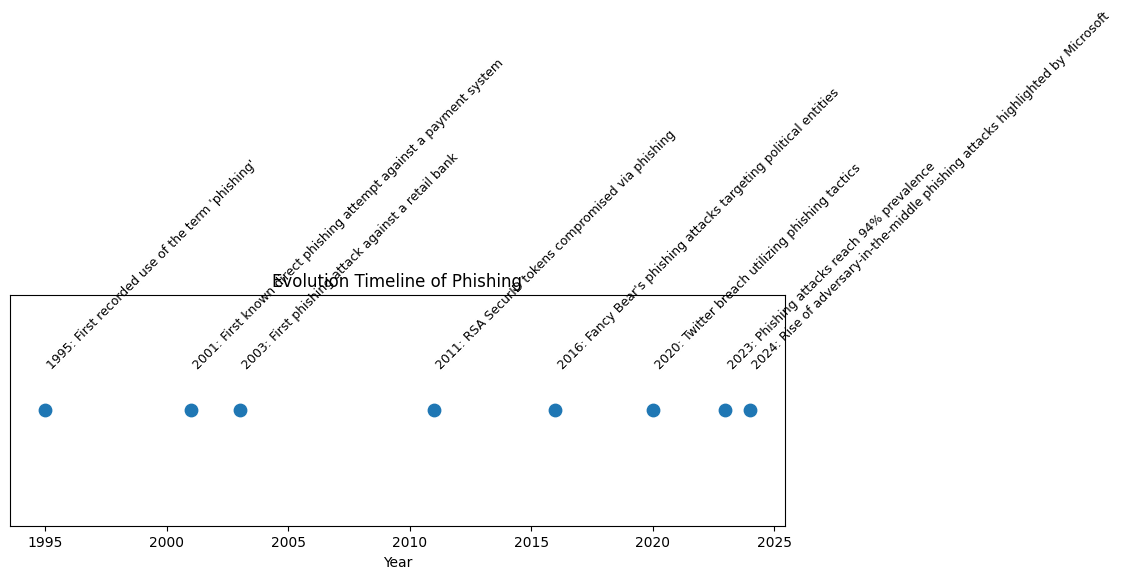

In [31]:
import matplotlib.pyplot as plt

# --- Use Phishing as example ---
dataset2 = trace_evolution("Phishing", dataset_objs)

# Parse year and event
years = []
events = []

for item in dataset2['timeline']:
    year = "".join([c for c in item.split(":")[0] if c.isdigit()])
    years.append(int(year) if year else None)
    events.append(item)

# Visualiztion
plt.figure(figsize=(10, 3))
plt.scatter(years, [1]*len(years), s=80)

for i, txt in enumerate(events):
    plt.text(years[i], 1.02, txt, rotation=45, ha="left", fontsize=9)

plt.yticks([])  # hide y-axis
plt.xlabel("Year")
plt.title(f"Evolution Timeline of {dataset2['technology']}")
plt.show()

### 4.4 Sample user interactions

In [32]:
class ResearchAssistant:
    """
    A 'conversation wrapper' that routes natural language questions to functions and organizes the output
    """
    def __init__(self, structured_results: List["TechInnovationExtraction"], model: str = "gpt-4o-mini"):
        self.client = OpenAI()
        self.model = model
        self.db = TechDB(structured_results)

    def _execute_tool(self, name: str, args: Dict[str, Any]) -> Dict[str, Any]:
        if name == "compare_technologies":
            return self.db.compare_technologies(args.get("tech1", ""), args.get("tech2", ""))
        elif name == "trace_evolution":
            return self.db.trace_evolution(args.get("technology", ""))
        else:
            return {"ok": False, "error": f"Unknown function: {name}"}

    def chat(self, user_content: str, context_hint: Optional[str] = None) -> str:
        """
        Closed-loop process:
	    1.	Send system + user + functions to the model, and let the model decide whether to call a function.
	    2.	If a function_call is triggered: execute the function locally → feed the result back with role="function".
	    3.	Request the model again to generate a natural language answer for the user.
        """
        system_msg = (
            "You are a Technology/Innovation research assistant. "
            "Use ONLY the provided functions to answer using the structured dataset. "
            "If the dataset lacks the requested item, be explicit and suggest what is missing."
        )
        msgs = [{"role": "system", "content": system_msg}]
        if context_hint:
            msgs.append({"role": "system", "content": f"Context hint: {context_hint}"})
        msgs.append({"role": "user", "content": user_content})

        # First request to the model → check whether to call a function
        resp = self.client.chat.completions.create(
            model=self.model,
            messages=msgs,
            functions=functions,
            function_call="auto"
        )
        msg = resp.choices[0].message

        # If the model triggers a function call
        if getattr(msg, "function_call", None):
            fn_name = msg.function_call.name
            try:
                fn_args = json.loads(msg.function_call.arguments or "{}")
            except Exception:
                fn_args = {}

            tool_result = self._execute_tool(fn_name, fn_args) # Execute the function locally

            # Feed back with role="function", name=function_name, content=JSON string
            msgs.append({
                "role": "function",
                "name": fn_name,
                "content": json.dumps(tool_result, ensure_ascii=False)
            })

            # Second request to the model → let it generate a natural language answer
            final = self.client.chat.completions.create(
                model=self.model,
                messages=msgs
            )
            return final.choices[0].message.content or ""
        else:
            # If no function call is triggered
            return msg.content or "I couldn't determine which function to use based on your question."

In [33]:
# ---------- Demo: interactive example ----------
assistant = ResearchAssistant(dataset_objs, model="gpt-4o-mini")

# Example 1: Compare two technologies
print(">>> compare two technologies")
print(assistant.chat("Compare credit card fraud and internet fraud. Highlight challenges vs mitigations."))

>>> compare two technologies
### Comparison of Credit Card Fraud and Internet Fraud 

**Common Applications:**
- **Overlap:**
  - E-commerce transactions (related)
  
- **Credit Card Fraud Specific:**
  - Mobile payments
  - Retail transactions
  - Subscription services
  
- **Internet Fraud Specific:**
  - Charity donations
  - Gift card transactions
  - Online dating platforms
  - Ticket sales

**Challenges:**
- **Overlap in Challenges:**
  - Increasing sophistication of fraud techniques/scams

- **Credit Card Fraud Specific Challenges:**
  - Difficulty of detecting fraud in real-time
  - High costs associated with fraud losses
  - Low reporting rates of fraud by victims
  
- **Internet Fraud Specific Challenges:**
  - Difficulty in tracing perpetrators
  - Legal and jurisdictional issues affecting enforcement
  - Victims may face penalties due to fraudulent donations

**Mitigations:**
- **Common Mitigation Strategies:**
  - User Education & Awareness

- **Overlap in Mitigations:**
 

In [34]:
# Example 2: Trace one technology
print(">>> trace one technology")
print(assistant.chat("Trace the evolution timeline of Regulatory Technology."))

>>> trace one technology
The evolution timeline of Regulatory Technology (RegTech) is as follows:

1. **2014**: The concept of RegTech was proposed by Andy Haldane.
2. **2015**: A report by the UK Government Chief Scientific Adviser noted the potential for FinTech in regulation.
3. **2015**: The Financial Conduct Authority (FCA) promoted the term "RegTech."

### Timeline Summary
- **First Year**: 2014
- **Latest Year**: 2015
- **Span of Years**: 1
- **Number of Events**: 3
- **Number of Years Labeled**: 3
- **Unique Years**: [2014, 2015]

### Key Innovations
- Regulatory monitoring
- Automated reporting and compliance
- Enhanced transparency in regulations

### Contributors
- Financial Conduct Authority (FCA)
- UK Government Chief Scientific Adviser
- Andy Haldane

### Applications
- Financial services
- Healthcare
- Gaming
- Pharmaceuticals
- Energy
- Aviation

### Challenges
- High costs of regulatory compliance
- Managing data volume and complexity
- Adapting to evolving regulatory 

#### 4.4.1 Error Handling of user interative part

In [35]:
# --- Enter the unlisted technology ---
print(">>> compare two technologies")
print(assistant.chat("Compare Ransomware and Phishing. Highlight challenges vs mitigations."))

>>> compare two technologies
It appears that the dataset does not contain information on Ransomware. Therefore, I can't provide a comparison between Ransomware and Phishing, including their challenges and mitigations, as I lack the necessary data on Ransomware.

If you have specific details or aspects you'd like to learn about Phishing alone, or if there's another technology or innovation you want to compare, please let me know!


## 5. Results and Analysis

### 5.1 Display of scraped data
- Scraped data is stored in scraped_articles, it's a List[Dict[Str, Any]].
- Useful information includes 'title', 'url', 'cleaned' (contents after text cleaning), cleaned_length.


In [36]:
data_summary = [
    {"Title": art['title'], 
    "Length": len(art['cleaned']), 
    "Preview": art['cleaned'][:200] + "..."} 
    for art in scraped_articles]
    
df_scraped = pd.DataFrame(data_summary)
df_scraped

,Title,Length,Preview
0,Fraud,68700,"From Wikipedia, the free encyclopedia\nIntenti..."
1,Credit card fraud,53157,"From Wikipedia, the free encyclopedia\nFinanci..."
2,Internet fraud,17646,"From Wikipedia, the free encyclopedia\nFraud o..."
3,Phishing,52402,"From Wikipedia, the free encyclopedia\nForm of..."
4,Multi-factor authentication,38215,"From Wikipedia, the free encyclopedia\nMethod ..."
5,Data analysis for fraud detection,20136,"From Wikipedia, the free encyclopedia\nData an..."
6,Regulatory technology,5823,"From Wikipedia, the free encyclopedia\nBusines..."


### 5.2 Structured extraction results

- Structured extraction results stored in structured_results dataset, it's a List[Dict[Str, Any]]. Extraction results stored in key='extraction'.
- In extraction, includes tech_name, summary, evolution_timeline, key_innovations, contributors, applications, challenges, mitigations.
- tech_name: str, summary: str, evolution_timeline: list, key_innovations: list, contributors: list, applications: list, challenges: list, mitigations: list


In [37]:
extr=[]
for r in structured_results:
    extr.append(r['extraction'].model_dump())

extr

data_struct = [
    {"Tech name": item['tech_name'], 
    "Summary": item['summary'][:200]+'...', 
    "Evolution Timeline": str(item['evolution_timeline'])[:200] + "...",
    "Key Innovations": str(item['key_innovations'])[:200]+'...',
    "Contributors": str(item['contributors'])[:200]+'...',
    "Applications": str(item['applications'])[:200]+'...',
    "Challenges": str(item['challenges'])[:200]+'...',
    "Mitigations": str(item['mitigations'])[:200]+'...'} 
    for item in extr]
    
df_struct = pd.DataFrame(data_struct)
df_struct

,Tech name,Summary,Evolution Timeline,Key Innovations,Contributors,Applications,Challenges,Mitigations
0,Fraud,Fraud is the intentional deception aimed at de...,[]...,[]...,[]...,"['Legal systems', 'Financial industry', 'Insur...",['Difficulties in proving intention to defraud...,"['Implementation of fraud detection systems', ..."
1,Credit card fraud,Credit card fraud is a type of financial crime...,['1970s: Introduction of credit cards for cons...,"['PCI DSS standards for secure processing', 'E...",['Payment Card Industry Security Standards Cou...,"['E-commerce transactions', 'Retail transactio...",['Increasing sophistication of fraud technique...,"['Regular monitoring of account transactions',..."
2,Internet fraud,Internet fraud is a form of cybercrime that ut...,"['1990s: Emergence of early online scams', '20...","['Social engineering tactics', 'Phishing techn...","['FBI', 'Center for Strategic and Internationa...","['E-commerce', 'Online dating platforms', 'Cha...","['Increasing sophistication of scams', 'Diffic...","['Use of secure payment methods', 'Educating u..."
3,Phishing,Phishing is a form of social engineering that ...,"[""1995: First recorded use of the term 'phishi...","['Use of spoofed login pages', 'Real-time rela...","['Khan C. Smith', 'Federal Bureau of Investiga...","['Cybersecurity', 'Identity theft prevention',...",['Increased sophistication of phishing schemes...,"['User education and awareness campaigns', 'Im..."
4,Multi-factor authentication,Multi-factor authentication (MFA) is an electr...,['1996: Concept of two-factor authentication v...,['Use of multiple types of authentication fact...,"['AT&T', 'Duo Security', 'Google', 'Apple', 'F...","['Financial services (banking)', 'E-commerce',...",['Susceptibility to phishing attacks and socia...,['Implementing education programs about phishi...
5,Data analysis for fraud detection,Data analysis for fraud detection involves var...,['2010: Article discusses the rise of speciali...,"['Knowledge discovery methods', 'Data mining t...","['Governments', 'Businesses', 'Forensic accoun...","['Financial services', 'E-commerce', 'Insuranc...",['Weaknesses in current internal control syste...,['Implementation of robust data analysis techn...
6,Regulatory technology,"Regulatory technology, or RegTech, utilizes in...","['2014: Concept proposed by Andy Haldane', '20...","['Regulatory monitoring', 'Automated reporting...","['Financial Conduct Authority (FCA)', 'UK Gove...","['Financial services', 'Healthcare', 'Gaming',...","['High costs of regulatory compliance', 'Manag...",['Automation of compliance and reporting proce...


### 5.3 Sample function calling conversations

**compare_technology function**
- compare_technology function will return useful items including overlap(strict matching), overlap_fuzzy(matching after using SentenceTransformer and Normalization), A_only_fuzzy (only tech A contains), B_only_fuzzy(only tech B contains), counts (count for A_only_fuzzy, B_only_fuzzy and intersection) for each field (applications, key innovations etc.)

In [38]:
compare_raw = compare_technologies("internet fraud", "credit card fraud", dataset_objs)

def compare_to_dataframe(result: dict) -> pd.DataFrame:
    # Extract names from two technologies
    techA = result["A"]
    techB = result["B"]
    
    # Dimensions need to display
    dimensions = ["applications", "contributors", "key_innovations", "challenges", "mitigation"]
    
    # Prepare to store row data
    rows = []
    for dim in dimensions:
        content = result.get(dim, {})
        # Extract fuzzy overlap and concatenate into a string
        overlap_fuzzy = [
            f"{p['A_raw']} ↔ {p['B_raw']} ({p['similarity']:.2f})"
            for p in content.get("overlap_fuzzy", [])
        ]
        row = {
            "Dimension": dim,
            "Overlap (fuzzy)": "; ".join(overlap_fuzzy) if overlap_fuzzy else "-",
            f"{techA} only": "; ".join(content.get("A_only_fuzzy", [])) or "-",
            f"{techB} only": "; ".join(content.get("B_only_fuzzy", [])) or "-"
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

df_compare = compare_to_dataframe(compare_raw)
print("Data frame preview for the output of compare_technologies:")
display(df_compare)

Data frame preview for the output of compare_technologies:


,Dimension,Overlap (fuzzy),Internet fraud only,Credit card fraud only
0,applications,E-commerce ↔ E-commerce transactions (0.77),Charity donations; Gift card transactions; Onl...,Mobile payments; Retail transactions; Subscrip...
1,contributors,-,Center for Strategic and International Studies...,Banks and financial institutions; Payment Card...
2,key_innovations,-,Automated bots for gift card fraud; Developmen...,EMV chip technology; Machine learning algorith...
3,challenges,Increasing sophistication of scams ↔ Increasin...,Difficulty in tracing perpetrators; Legal and ...,Difficulty of detecting fraud in real-time; Hi...
4,mitigation,Educating users about scams ↔ Customer educati...,AI-powered bots to engage and distract scammer...,Implementation of PCI DSS compliance; Regular ...


**trace_evolution function**
- trace_evolution function will return a dictionary item.
- useful keys including timeline and timeline_summary (contains first_year, latest_year, span_years, n_events etc.)

In [39]:
evo_raw = trace_evolution("internet fraud", dataset_objs)

data_evo = [
    {"Tech name": evo_raw['technology'], 
    "Summary": evo_raw['summary'][:200]+'...', 
    "Timeline": str(evo_raw['timeline'])[:200] + "..."}
    ]

print("Data frame preview for the output of trace_evolution:")
df_evo=pd.DataFrame(data_evo)
display(df_evo)

Data frame preview for the output of trace_evolution:


,Tech name,Summary,Timeline
0,Internet fraud,Internet fraud is a form of cybercrime that ut...,"['1990s: Emergence of early online scams', '20..."


## 6. Research Insights and Reflection

### 6.1 Key insights discovered about your chosen domain through the analysis

- Fraud is concentrated in e-commerce and online shopping transactions, but with increasing digitalization, more phishing techniques have emerged, such as Man-in-the-Middle (MitM) phishing, QR code phishing (Quishing), and Adversary-in-the-Middle (AiTM) phishing.

- The rise of Phishing-as-a-Service (PhaaS) may indicate that fraud has already become industrialized and commercialized.

- Anti-fraud techniques are also evolving, such as the adoption of AI/ML for real-time analytics and geolocation in fraud detection, and the use of multi-factor authentication (security tokens, authenticator apps, biometrics, and dynamic passcodes).

- However, several major challenges remain:
	1.	Fraud techniques are evolving rapidly, while anti-fraud measures are often updated only after new types of fraud are discovered.
	2.	Fraud detection relies heavily on large datasets to improve accuracy, but faces three challenges: privacy protection, data gaps, and high false-positive rates.
	3.	Cross-border law enforcement remains difficult.

- Currently, the primary methods to reduce fraud risks include: raising user awareness of different fraud schemes (most important), followed by multi-factor authentication (MFA), and then regular updates to fraud prevention and detection technologies.

- The rise of RegTech demonstrates that regulators, not just fraudsters, are also innovating by leveraging technology to reduce costs, improve transparency, and enhance compliance.

- In addition, with regard to cross-border fraud, I believe it is essential to strengthen global collaborative law enforcement in the future.

### 6.2 Design decisions and code structure explanation

1. Scraping
-  I defined a class `WikipediaScraper`, with function `scrape_article` to scrape single article, and function `scrape_multiple` to call scrape_article multiple times. It's responsible for scraping and cleaning data.

- Implemented retry logic and request throttling to avoid failures or blocking; `_validate_article` detects soft 404s, disambiguation pages, and thin content to ensure data quality.

- The `clean_content` method removes references, footnotes, and footer noise, keeping only the main text. `_extract_title_from_markdown` ensures every record has a valid title.

- Returns structured results containing both status and invalid_reason, making it easier for subsequent batch processing and analysis.


2. Structure Data Extraction
- The 8 fields include tech_name, summary (a general introduction of the technology), evolution_timeline (with year and event, used to trace the evolution of the technology); key_innovations and contributors are designed to answer the questions listed in the Assignment 1 PDF document; applications, challenges, and mitigations are fields that I am particularly interested in, and they also facilitate subsequent comparisons between technologies.

- The `StructuredExtractor` is dedicated to converting scraped text into structured data that conforms to the Pydantic model.

- Designed `_classify_api_error` and `_compute_backoff` to automatically retry on timeout or rate-limiting errors, while stopping immediately for parameter or authentication errors.

- The `_build_prompt` method explicitly defines schema fields to ensure model outputs align with TechInnovationExtraction

3. Function Calling
- First perform _normalize_phrase to get a strict intersection, then apply Sentence-Transformer embeddings + cosine similarity for fuzzy matching, balancing precision and semantics, and revealing commonalities and differences between two technologies.

- Use a similarity threshold (e.g., 0.68) as a parameter to balance recall and precision; unmatched items are output separately to A_only_fuzzy / B_only_fuzzy.

- `_index_by_name / _normalize_phrase / _soft_pairs_semantic / dim_soft_semantic` decouple indexing, normalization, pairing, and dimensional aggregation, which makes unit testing and maintenance easier.

- Handle empty lists or missing fields safely (`_as_list`), return clear error messages (ok=False) when no matches are found, and gracefully degrade when embedding fails or yields empty sets.


### 6.3 Challenges faced and solutions implemented

1. **Difficulty recognizing semantically similar phrases**  
   *Challenge*: Phrases like *“Online marketplace transactions”* and *“E-commerce transactions”* have similar meanings but were too different for exact matching.  
   *Solution*: Introduced **Sentence-Transformer embeddings** with a cosine similarity threshold (e.g., 0.68) to capture semantic similarity.

2. **Semantically close phrases still not matched after using embeddings**  
   *Challenge*: Items such as *“Public awareness campaigns”*, *“Educating users on security best practices”*, *“User awareness and susceptibility”*, *“User education and training”* are all related to user education/awareness but did not cluster automatically.  
   *Solution*: Implemented a `_normalize_phrase` function with regex rules (e.g., if the phrase contains education|educat|awareness, map all to *“User Education & Awareness”*) to unify categories.

3. **Noisy or overly long content affecting extraction stability**  
   *Challenge*: Some Wikipedia articles were too long and contained noise (e.g., References sections, [edit] markers), reducing extraction quality.  
   *Solution*: Enhanced `clean_content` to trim text, remove footnotes and redundant sections, and keep only the main body for more stable extraction.

4. **Handling invalid or disambiguation pages**  
   *Challenge*: Some Wikipedia links led to disambiguation pages (lists of links) or non-existent pages, which still returned scraped text.  
   *Solution*: Added validation in `WikipediaScraper._validate_article` to detect soft-404/disambiguation signals, filter out invalid data, and record invalid_reason for transparency.

5. **tech_name changes each time**

   *Challenges*: the tech_name of Regulatory Technology will change each time, either Regulatory Technology or Regulatory Technology (RegTech).
   *Solution*: add "use ONLY the article title exactly as given (do not include aliases or parentheses" for tech_name in Pydantic model.


### 6.4 What meaningful patterns or connections did your assistant uncover?

From the conversations in **4.4**:

- **Credit Card Fraud vs. Internet Fraud**: Both share challenges around the increasing sophistication of fraud and emphasize **User Education & Awareness**.  
  - However, Credit Card Fraud leans on industry standards and compliance (PCI DSS, transaction monitoring), while Internet Fraud relies more on cross-platform collaboration and secure payment practices.  
  - This illustrates a pattern of “common defenses + domain-specific governance.”

- **RegTech** rapidly evolved from concept (2014) to institutional endorsement (2015), showing it was policy- and regulator-driven from the start rather than purely market-led.  


More generally:

- **Shared vs. unique mitigations**: Many technologies emphasize **User Education & Awareness** as a universal defense, while others (e.g., Credit Card Fraud) highlight industry-specific standards such as **EMV** and **PCI DSS**.

- **Evolving attacker–defender dynamics**: Timelines show a “two-sided innovation” loop—fraud tactics become more sophisticated (e.g., phishing → AiTM), and defenses escalate in response (e.g., MFA, real-time monitoring, RegTech).

- **Cross-domain collaboration**: Contributors include regulators, banks, tech companies, and researchers, suggesting that fraud prevention is not purely technical but requires multi-stakeholder cooperation.

### 6.5 What you learned from this assignment

I really learned a lot from this assignment including 
- Learning how to scrape articles from websites using the crawl4ai tools and understanding how asynchronous functions work.
- Understanding the importance of using backoff strategies to avoid sending requests too frequently and failing the scraping process.
- Realizing the need for proper error handling in code—not just making sure it runs, but ensuring it runs reliably.
- Gaining a clear view of the end-to-end pipeline: from scraping → extracting structured data → function calling → interacting with an LLM.
- Learning about the evolution of fraud and anti-fraud techniques (from traditional methods to digitalized approaches), as well as the latest fraud tactics such as Man-in-the-Middle (MitM) phishing and Adversary-in-the-Middle (AiTM) phishing.
- Recognizing that many companies and agencies (e.g., Payment Card Industry Council, Microsoft, McAfee, AI/ML researchers) are contributing to the advancement of anti-fraud technologies.